<a href="https://colab.research.google.com/github/EugenHotaj/pytorch-generative/blob/master/notebooks/__draft__gaussian_processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, spatial

In [126]:
def sausage_plot(X, Y=None, mu=None, sigma=None, fn=None, obs_X=None):
    """Creates a sausage plot of a 1D Gaussian process. 

    Args:
        X: (n x 1) array containing the x-axis coordinates.
        Y: (n x k) array containing k samples drawn from the Gaussian process at X.
        mu: (n x 1) array containing the marginal means at X.
        sigma: (n x 1) array containing the marginal stds at X. If provided, the 95% 
            credible intervals around mu are plotted.
        fn: The true function being modeled by the Gaussian process. If provided, fn(X) 
            is plotted.
        obs_X: (n x 1) array containing x-axis coordinates of observations. If provided, 
            f(obs_X) are plotted.
    """
    assert any([Y is not None, mu is not None, sigma is not None, fn is not None])

    fig = plt.figure(figsize=(20, 4))
    y_max = []

    # Plot mean and credible intervals.
    if sigma is not None:
        assert mu is not None, "mu cannot be None when sigma is not None."
        lower_bound, upper_bound = mu - 1.96 * sigma, mu + 1.96 * sigma
        plt.fill_between(X, lower_bound, upper_bound, facecolor='lightblue')
        y_max.extend([lower_bound, upper_bound])
    if mu is not None:
        plt.plot(X, mu, c="tab:blue")
        y_max.append(mu)

    # Plot samples.
    if Y is not None:
        for i in range(Y.shape[0]): 
            sample = Y[i, :]
            plt.plot(X, sample, color="tab:orange")
            y_max.append(sample)

    # Plot the true function and observations.
    if fn is not None:
        Y = fn(X) 
        plt.plot(X, Y, color="tab:red", linestyle="dashed")
        y_max.append(Y)
    if obs_X is not None:
        assert fn is not None, "fn cannot be None when obs_X is not None."
        Y = fn(obs_X)
        plt.scatter(obs_X, Y, color="tab:red")
        y_max.append(Y)

    # Set axis limits.
    plt.xlim(X.min(), X.max())
    y_max = max([np.abs(y).max() for y in y_max])
    plt.ylim(-y_max - .5, y_max + .5)

    plt.show()

In [132]:
class GaussianProcess:
    def __init__(self, mean_fn, cov_fn):
        self.mean_fn = mean_fn
        self.cov_fn = cov_fn
        self.x_obs = []
        self.y_obs = []

    def fit(self, x, y):
        self.x_obs.append(x)
        self.y_obs.append(y)

    def _sample(self, mu, sigma, n_samples):
        return np.random.multivariate_normal(mu, sigma, size=n_samples)

    def _sample_prior(self, x, n_samples):
        mu = self.mean_fn(x).reshape(-1)
        sigma = self.cov_fn(x, x)
        samples = self._sample(mu, sigma, n_samples)
        return mu, sigma, samples

    def sample(self, x, n_samples=1):
        if not self.x_obs:
            return self._sample_prior(x, n_samples)

        # Compute means and covariances.
        x_obs, y_obs = np.stack(self.x_obs), np.stack(self.y_obs)
        mu_obs, mu_x = self.mean_fn(x_obs), self.mean_fn(x)
        sigma_obs, sigma_x = self.cov_fn(x_obs, x_obs), self.cov_fn(x, x)
        sigma_obs_x = self.cov_fn(x_obs, x)

        # Compute posterior mean and covariance.
        solved = linalg.solve(sigma_obs, sigma_obs_x, assume_a="pos").T 
        mu = (solved @ y_obs).flatten()
        sigma = sigma_x - (solved @ sigma_obs_x)
        samples = self._sample(mu, sigma, n_samples)

        return mu, sigma, samples

In [128]:
domain = -6, 6
n_grid = 100
n_train = 5
n_samples = 4

def f(x):
    return np.sin(x)

grid_x = np.linspace(*domain, n_grid)
grid_y = f(grid_x)
train_x = np.random.uniform(*domain, size=(n_train, 1))
train_y = f(train_x)

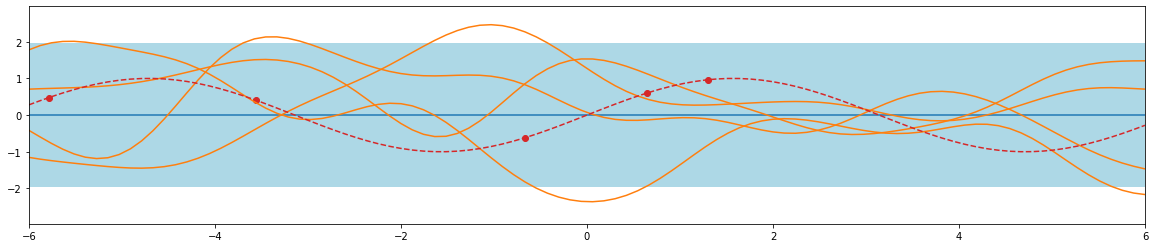

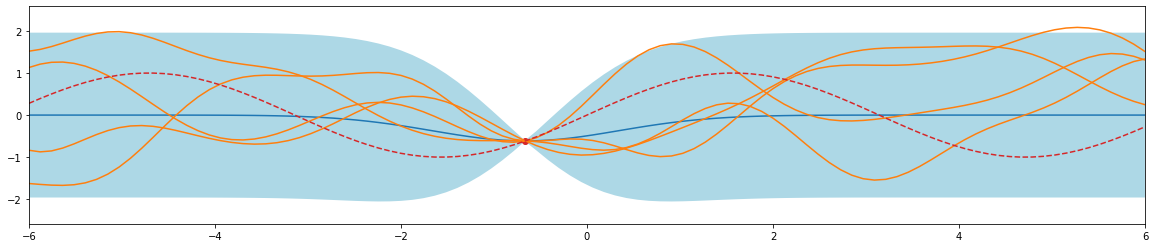

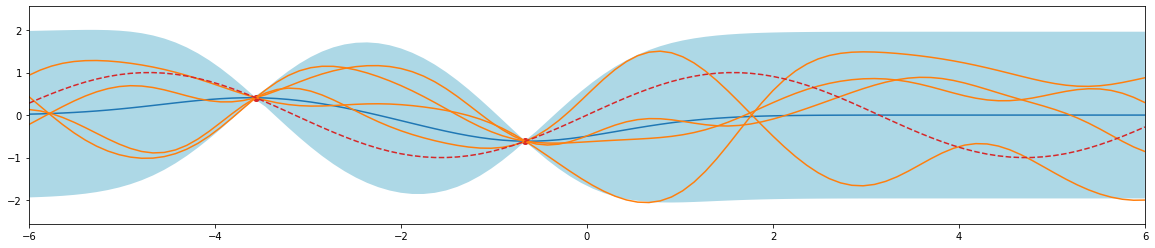

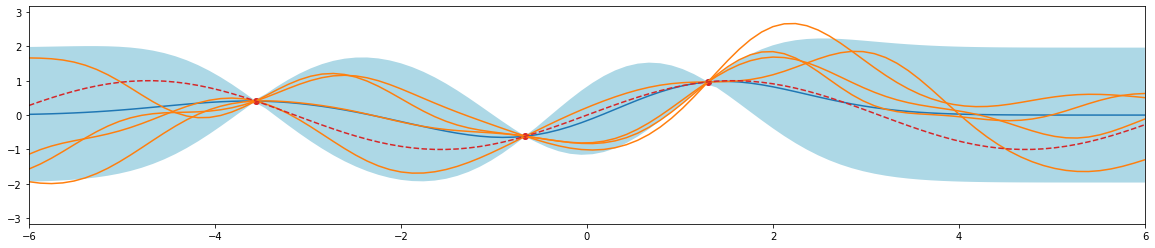

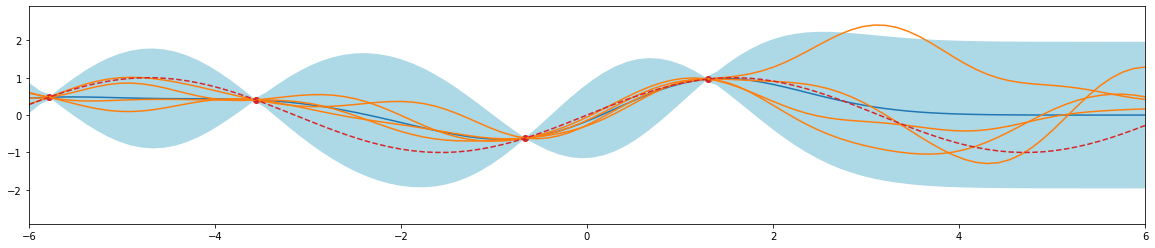

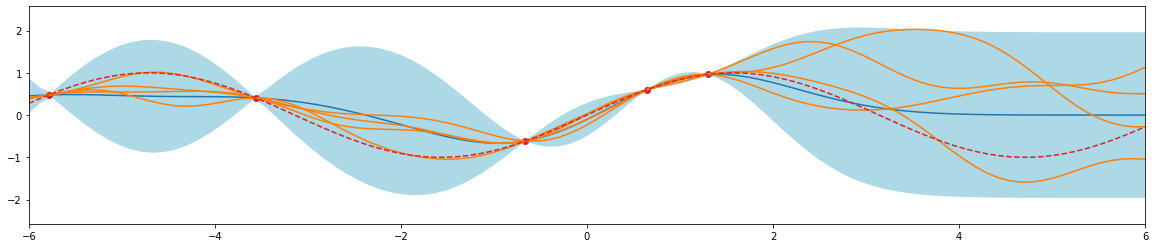

In [133]:
mean_fn = np.zeros_like

def cov_fn(left, right):
    left, right = left.reshape(-1, 1), right.reshape(-1, 1)
    return np.exp(-.5 * spatial.distance.cdist(left, right, 'cityblock')**2)

gp = GaussianProcess(mean_fn, cov_fn)

# Sample from prior.
mu, sigma, samples = gp.sample(grid_x.reshape(-1, 1), n_samples)
sausage_plot(grid_x, samples, mu, np.sqrt(np.diag(sigma)), f, train_x)

# Sample from posterior.
for i in range(len(train_x)):
    gp.fit(train_x[i], train_y[i])
    mu, sigma, samples = gp.sample(grid_x.reshape(-1, 1), n_samples)
    sausage_plot(grid_x, samples, mu, np.sqrt(np.diag(sigma)), f, train_x[:(i+1)])